### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from itertools import permutations
import collections
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('/content/lang_data.csv')

In [3]:
df.head()

,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English


### Analysing the given data

In [4]:
df.shape

(2839, 2)

In [5]:
df['language'].unique()

array(['English', 'Afrikaans', 'Nederlands'], dtype=object)

In [6]:
df['language'].value_counts()

language
English       2077
Afrikaans      671
Nederlands      91
Name: count, dtype: int64

In [7]:
# Normally we'd want to have equal amount of labels, but here we see they are not distributed equally. This may lead to unbalanced fitting of the model.

In [8]:
df['language'].isna().sum()

0

In [9]:
df['text'].isna().sum()

78

In [10]:
df = df[df['text'].notna()]
df.shape

(2761, 2)

In [11]:
# Since the data is object type and we'd want to do string operations on the data, lets convert the data to string type.
df['text'] = df['text'].astype(str)
df['language'] = df['language'].astype(str)

<ipython-input-11-8bd2e36ff05c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str)
<ipython-input-11-8bd2e36ff05c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['language'].astype(str)


### Creating new features for input data

In [12]:
punc = ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?")
vowels=['a','e','i','o','u']

same_consecutive_vowels = ['aa','ee', 'ii', 'oo', 'uu']
consecutive_vowels = [''.join(p) for p in permutations(vowels,2)]
dutch_combos = ['ij']

In [13]:
df['word_count'] = df['text'].apply(lambda x : len(x.split()))
df['character_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['character_count'] + 1)
df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punc]))
df['v_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'v']))
df['w_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'w']))
df['ij_char_count'] = df['text'].apply(lambda x : sum([any(d_c in a for d_c in dutch_combos) for a in x.split()]))
df['num_double_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in same_consecutive_vowels) for a in x.split()]))
df['num_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in consecutive_vowels) for a in x.split()]))
df['num_vowels'] = df['text'].apply(lambda x : sum([any(v in a for v in vowels) for a in x.split()]))
df['vowel_density'] = df['num_vowels']/df['word_count']
df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['character_count']),axis=1)
df['num_exclamation_marks'] =df['text'].apply(lambda x: x.count('!'))
df['num_question_marks'] = df['text'].apply(lambda x: x.count('?'))
df['num_punctuation'] = df['text'].apply(lambda x: sum(x.count(w) for w in punc))
df['num_unique_words'] = df['text'].apply(lambda x: len(set(w for w in x.split())))
df['num_repeated_words'] = df['text'].apply(lambda x: len([w for w in collections.Counter(x.split()).values() if w > 1]))

<ipython-input-13-1264d4f80c54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['text'].apply(lambda x : len(x.split()))
<ipython-input-13-1264d4f80c54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['character_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
<ipython-input-13-1264d4f80c54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [14]:
df.head()

,text,language,word_count,character_count,word_density,punc_count,v_char_count,w_char_count,ij_char_count,num_double_consec_vowels,num_consec_vowels,num_vowels,vowel_density,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_unique_words,num_repeated_words
0,Ship shape and Bristol fashion,English,5,26,0.185185,0,0,0,0,0,1,5,1.000000,2,0.076923,0,0,0,5,0
1,Know the ropes,English,3,12,0.230769,0,0,1,0,0,0,3,1.000000,1,0.083333,0,0,0,3,0
2,Graveyard shift,English,2,14,0.133333,0,1,0,0,0,0,2,1.000000,1,0.071429,0,0,0,2,0
3,Milk of human kindness,English,4,19,0.200000,0,0,0,0,0,0,4,1.000000,1,0.052632,0,0,0,4,0
4,Touch with a barge-pole - Wouldn't,English,6,29,0.200000,3,0,2,0,0,2,5,0.833333,2,0.068966,0,0,3,6,0


### Correlation Matrix

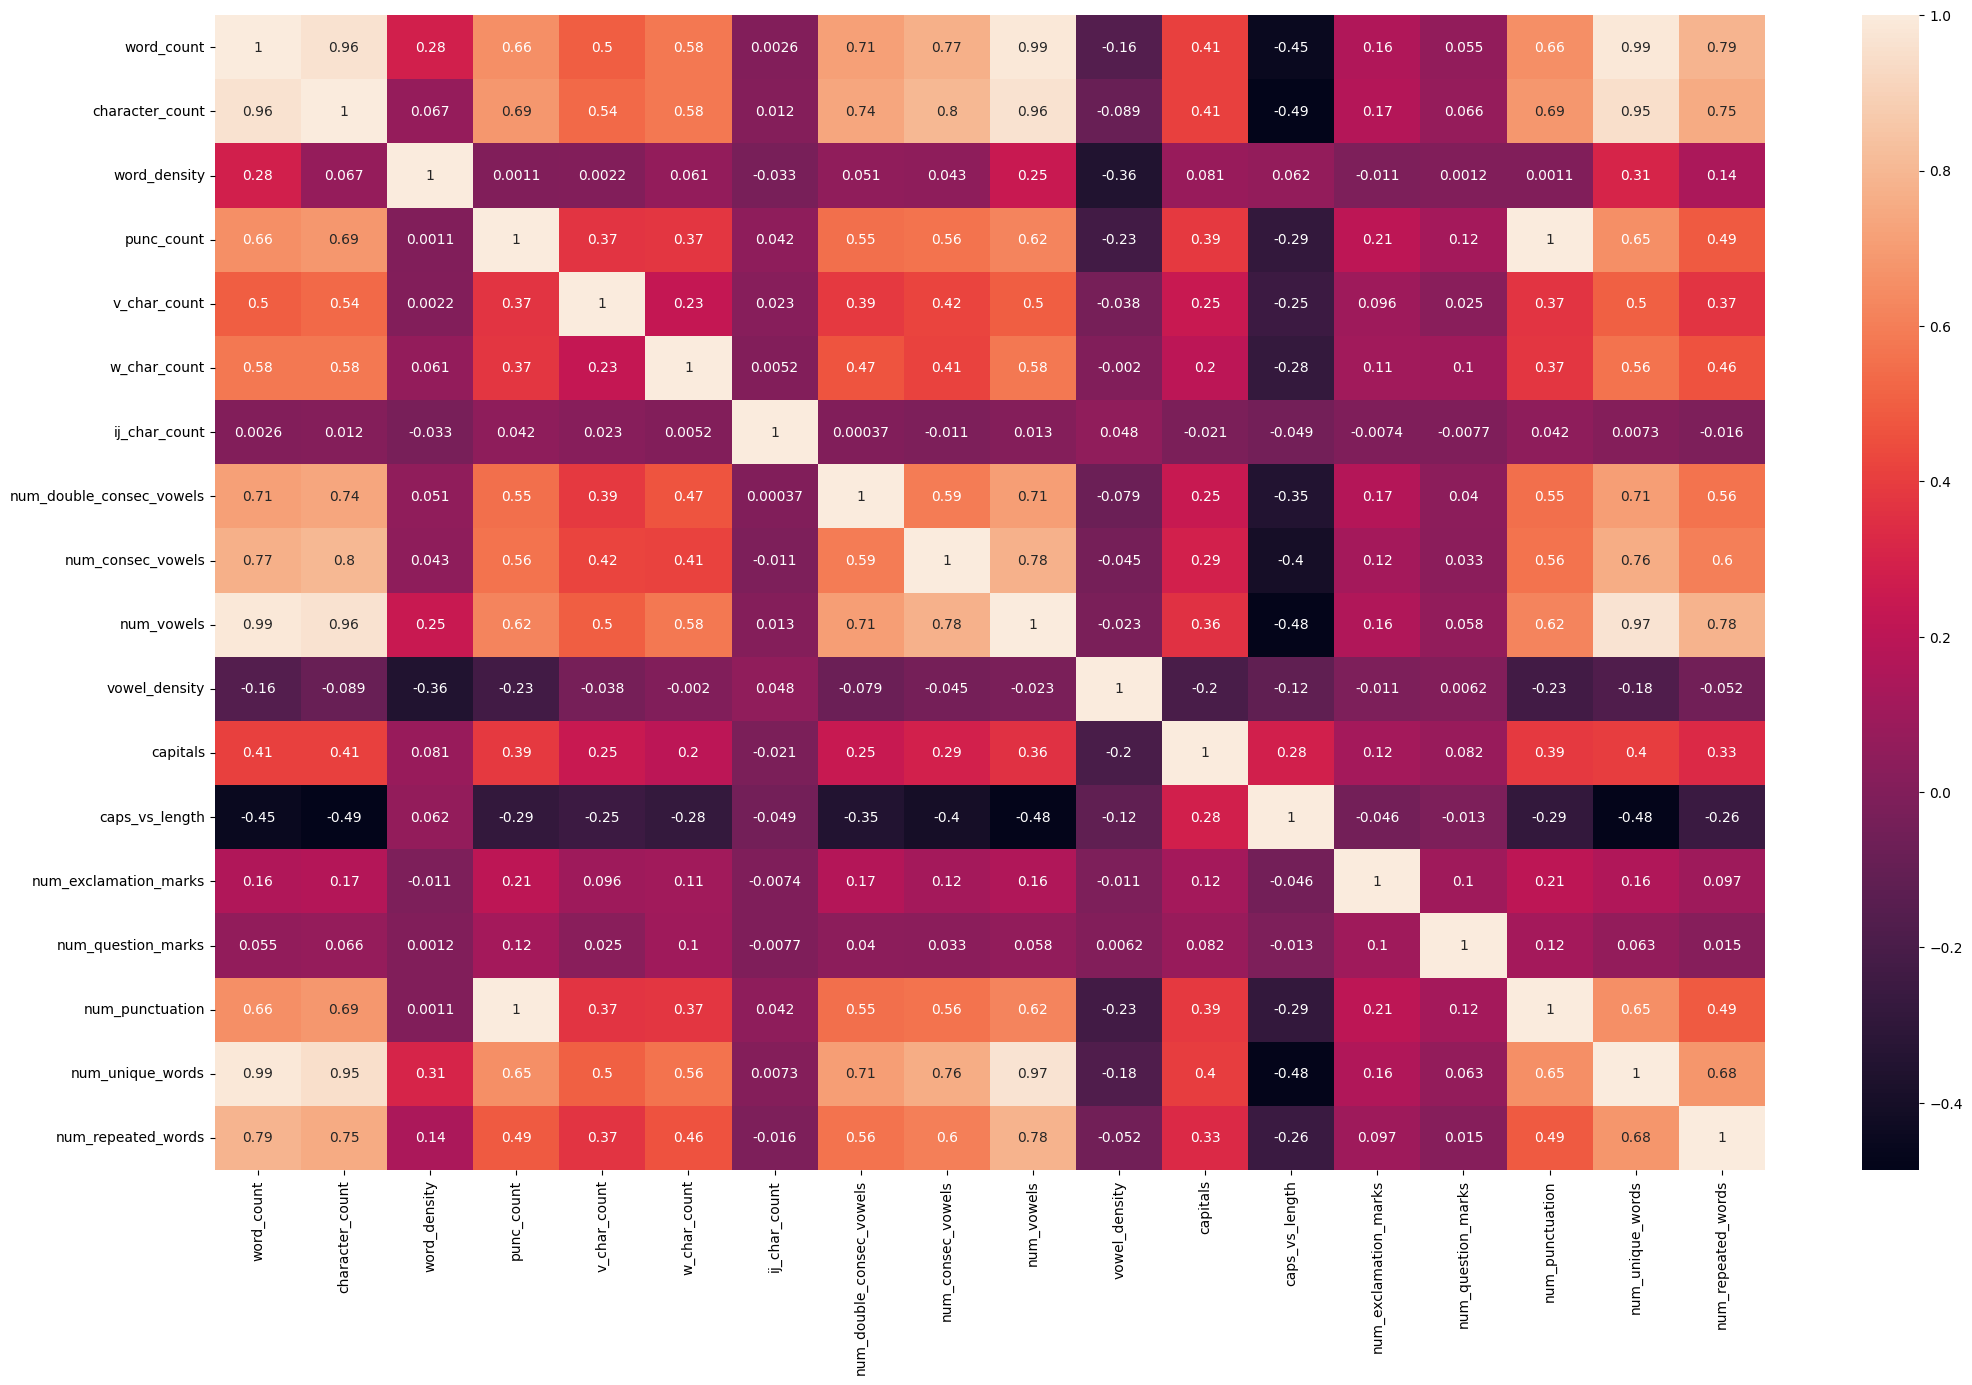

In [15]:
corr_matrix = df.drop(['text', 'language'], axis=1).corr()
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [16]:
X = df.drop(['text', 'language'], axis=1)
y = df['language']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32, shuffle=True)

In [18]:
X_train.shape, y_train.shape

((2208, 18), (2208,))

In [19]:
X_test.shape, y_test.shape

((553, 18), (553,))

### PCA for dimensionality reduction

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [21]:
pca.n_components_

12

In [22]:
# We'll be using these components as our input to the data

In [23]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [24]:
classes = label_encoder.classes_
classes

array(['Afrikaans', 'English', 'Nederlands'], dtype=object)

In [25]:
print("Label Mapping:")
for numerical_label, original_label in enumerate(classes):
    print(f"{numerical_label}: {original_label}")

Label Mapping:
0: Afrikaans
1: English
2: Nederlands


### Using SVM classifier to train and classify

In [26]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8987341772151899


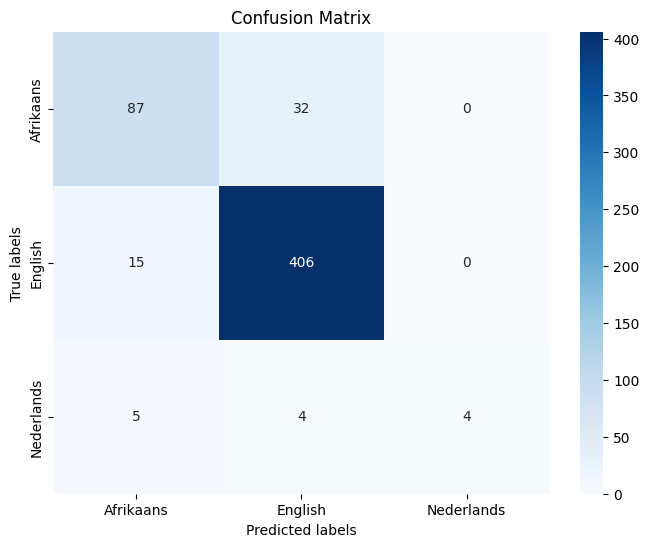

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
